# Preprocess and Save the data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
import joblib

class Preprocessor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = AutoModel.from_pretrained('bert-base-uncased').to(self.device)
        self.tfidf = TfidfVectorizer(max_features=100)

    def extract_bert_embeddings(self, texts, batch_size=32):
        # Extract BERT embeddings in batches
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size].tolist()
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
        return np.vstack(embeddings)

    def preprocess(self, df):
        # Compute BERT embeddings
        prompt_embeddings = self.extract_bert_embeddings(df['prompt'])
        response_a_embeddings = self.extract_bert_embeddings(df['response_a'])
        response_b_embeddings = self.extract_bert_embeddings(df['response_b'])

        # Compute TF-IDF features
        tfidf_features = self.tfidf.fit_transform(df['prompt']).toarray()

        # Combine features
        features = np.hstack([
            prompt_embeddings,
            response_a_embeddings,
            response_b_embeddings,
            tfidf_features
        ])

        return features

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Initialize preprocessor
preprocessor = Preprocessor()

# Preprocess and save train data
X_train = preprocessor.preprocess(train_df)
np.save('X_train.npy', X_train)

# Preprocess and save test data
X_test = preprocessor.preprocess(test_df)
np.save('X_test.npy', X_test)

# Save targets
y_train = np.zeros(len(train_df))
y_train[train_df['winner_model_a'] == 1] = 0
y_train[train_df['winner_model_b'] == 1] = 1
y_train[train_df['winner_tie'] == 1] = 2
np.save('y_train.npy', y_train)

print("Preprocessing complete. Features and targets saved.")


# Training the model

In [2]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load preprocessed features and targets
X = np.load('data2/X_train.npy')
y = np.load('data2/y_train.npy')

# Compute class weights to handle imbalance
class_weights = {0: 1.0, 1: 1.0, 2: 1.5}  # Adjust based on class distribution
weights = np.array([class_weights[label] for label in y])

# Split data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)

# Set LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_data_in_leaf': 50,
    'max_bin': 256
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, weight=weights_train)
val_data = lgb.Dataset(X_val, label=y_val, weight=weights_val, reference=train_data)

# Train the model with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=200,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Evaluate the model
y_val_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Generate a classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Save the trained model
model.save_model('trained_model2.txt')
print("Model trained and saved as 'trained_model2'.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.932959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615348
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 2404
[LightGBM] [Info] Start training from score -1.194858
[LightGBM] [Info] Start training from score -1.210551
[LightGBM] [Info] Start training from score -0.918243
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.761847	valid_1's multi_logloss: 1.03101
Validation Accuracy: 0.4501
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.38      0.44      2794
         1.0       0.51      0.38      0.44      2750
         2.0       0.38      0.60      0.47      2456

    accuracy                           0.45      8000
   macro avg       0.47      0.46      0.45      800

# Metrics and Accuracy

Accuracy on Validation Data: 45.01%
RMSE on Validation Data: 0.4586
Log Loss on Validation Data: 1.0477

Classification Report:
              precision    recall  f1-score   support

     Model A       0.51      0.38      0.44      2794
     Model B       0.51      0.38      0.44      2750
         Tie       0.38      0.60      0.47      2456

    accuracy                           0.45      8000
   macro avg       0.47      0.46      0.45      8000
weighted avg       0.47      0.45      0.45      8000


Confusion Matrix:
[[1075  530 1189]
 [ 525 1044 1181]
 [ 502  472 1482]]


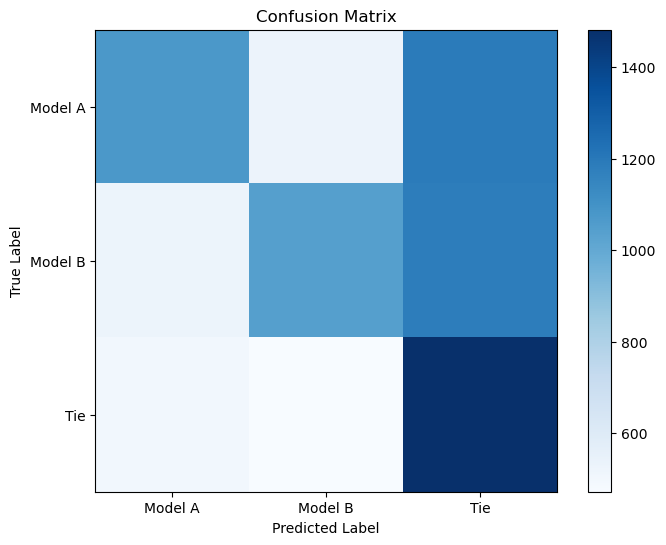

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load data
X_train = np.load('data2/X_train.npy')  # Features
y_train = np.load('data2/y_train.npy')  # True labels

# Ensure y_train is of integer type
y_train = y_train.astype(int)

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Load the trained model
model = lgb.Booster(model_file='trained_model2.txt')

# Predict probabilities on the validation set
val_probs = model.predict(X_val_split)

# Convert probabilities to predicted classes
val_preds = np.argmax(val_probs, axis=1)

# Accuracy
accuracy = accuracy_score(y_val_split, val_preds)
print(f"Accuracy on Validation Data: {accuracy * 100:.2f}%")

# RMSE
# Prepare one-hot-encoded true labels for RMSE calculation
y_val_one_hot = np.zeros_like(val_probs)
y_val_one_hot[np.arange(len(y_val_split)), y_val_split] = 1  # One-hot encoding
rmse = np.sqrt(mean_squared_error(y_val_one_hot, val_probs))
print(f"RMSE on Validation Data: {rmse:.4f}")

# Log Loss
logloss = log_loss(y_val_split, val_probs)
print(f"Log Loss on Validation Data: {logloss:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_split, val_preds, target_names=["Model A", "Model B", "Tie"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_split, val_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1, 2], labels=["Model A", "Model B", "Tie"])
plt.yticks(ticks=[0, 1, 2], labels=["Model A", "Model B", "Tie"])
plt.show()